# Softmax Regression

Implementing Softmax function to classify MNIST data

## Display MNIST dataset

First of all, lets view some of the images in the dataset.

Two approaches of extracting images from "idx3-ubyte" file:
1. Using a library, idx2numpy, that wraps the code for extracting the data vector and simplifies the process.
2. Write the code yourself by using struct and matplotlib.

I will follow both approaches and write code for either one.

### Using idx2numpy library

In [1]:
# import idx2numpy

# def load_mnist_images(file_path):
#     images = idx2numpy.convert_from_file(file_path)
#     return images

# def load_mnist_labels(file_path):
#     labels = idx2numpy.convert_from_file(file_path)
#     return labels

In [2]:
# def get_images_using_idx2numpy(image_file, label_file):
#     """
#     Load MNIST images and labels using idx2numpy.
#     """
#     images = load_mnist_images(image_file)
#     labels = load_mnist_labels(label_file)
    
#     return images, labels

### Write code for extracting image data yourself

In [3]:
import struct
import torch

def load_mnist_images_manual(image_path, label_path):
    with open (image_path, 'rb') as img_file:
        # Read the header
        magic, num_images, rows, cols = struct.unpack('>IIII', img_file.read(16))

        print(f"Magic: {magic}, Number of Images: {num_images}, Rows: {rows}, Columns: {cols}")

        # Read the image data
        image_data = img_file.read(rows * cols * num_images)
        images = torch.frombuffer(image_data, dtype=torch.uint8)

        images = images.reshape((num_images, rows, cols))

    with open (label_path, 'rb') as lbl_file:
        # Read the header
        magic, num_labels = struct.unpack('>II', lbl_file.read(8))

        print(f"Magic: {magic}, Number of Labels: {num_labels}")

        # Read the label data
        label_data = lbl_file.read(num_labels)
        labels = torch.frombuffer(label_data, dtype=torch.uint8)

    return images, labels

### Display Images using either approaches

In [4]:
# Display some random images
import matplotlib.pyplot as plt
import math

def display_images(images, labels):
    cols = 4
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(20, 10))
    index = 0
    
    for x in zip(images, labels):
        image = x[0]
        label = x[1]
        plt.subplot(rows, cols, index + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        index += 1

Magic: 2051, Number of Images: 60000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 60000


C:\Users\sujan\AppData\Local\Temp\ipykernel_37352\1143474224.py:13: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:1567.)
  images = torch.frombuffer(image_data, dtype=torch.uint8)


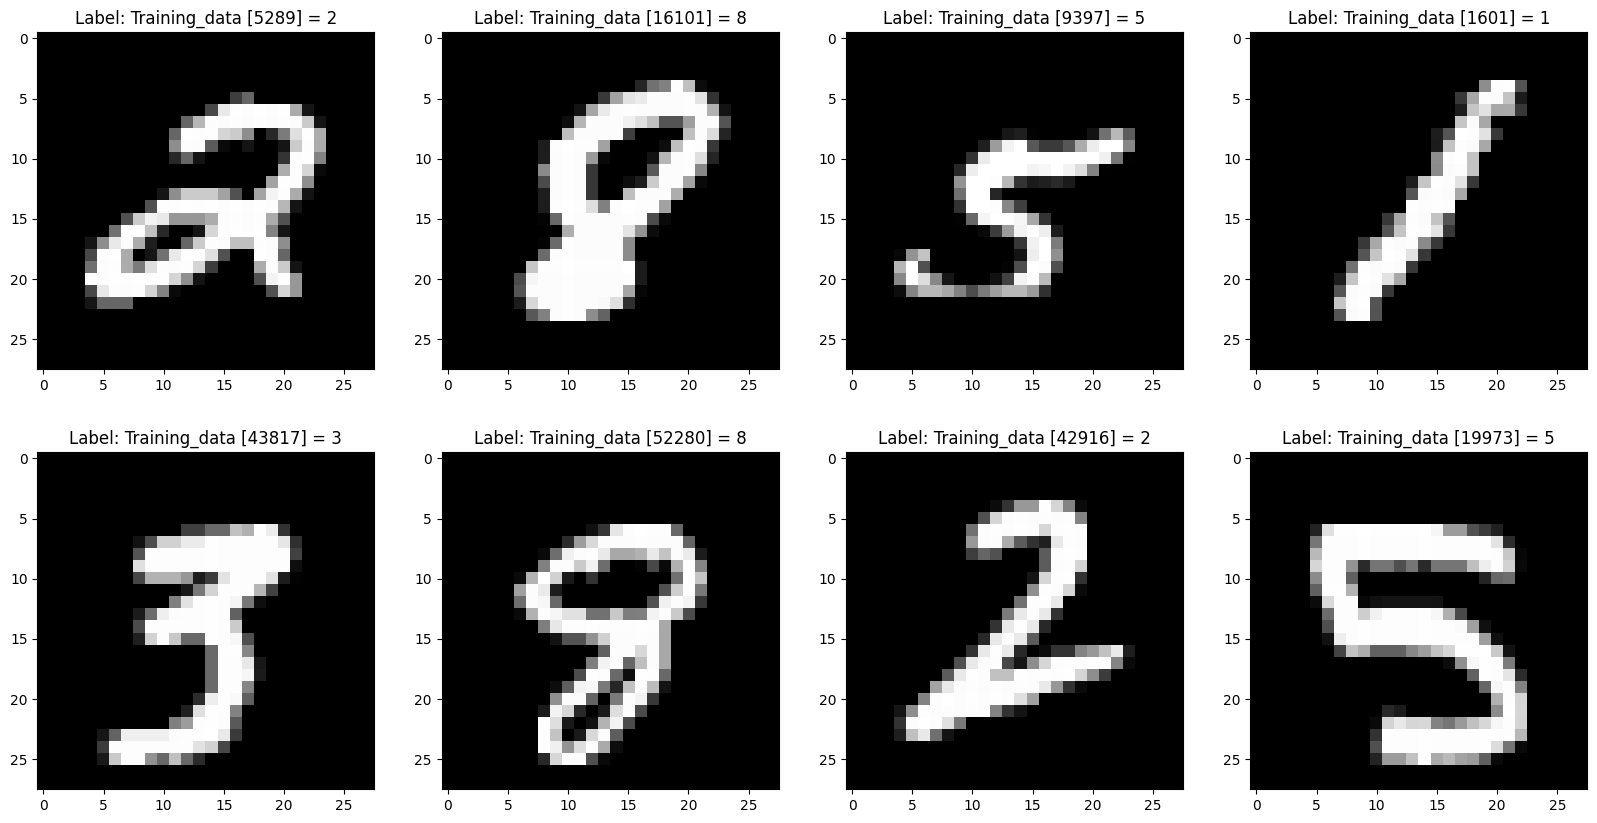

In [5]:
import random

images_to_display = []
labels_to_display = []

# images, labels = get_images_using_idx2numpy(
#     "dataset/train-images.idx3-ubyte", 
#     "dataset/train-labels.idx1-ubyte"
# )

images, labels = load_mnist_images_manual(
    "dataset/train-images.idx3-ubyte", 
    "dataset/train-labels.idx1-ubyte"
)

for i in range(8):
    ran_idx = random.randint(0, labels.shape[0] - 1)
    images_to_display.append(images[ran_idx])
    labels_to_display.append("Training_data [" + str(ran_idx) + "] = " + str(labels[ran_idx].item()))



display_images(images_to_display, labels_to_display)

## Preprocessing of Data

Now, we have a numerical data of images as matrix representation. We perform pre-processings before classifying the data to one of the labels.
1. Flatten the images into 1D vector
2. Scale the pixel values to [0, 1]
3. Encode the labels

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Flatten the 2D images (28 * 28) to 1D vector

In [7]:
X_train, y_train = load_mnist_images_manual(
    "dataset/train-images.idx3-ubyte", 
    "dataset/train-labels.idx1-ubyte"
)

X_train = X_train.to(device)
y_train = y_train.to(device)

Magic: 2051, Number of Images: 60000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 60000


In [8]:
print(f"2D shape of X_train: {X_train.shape}")

2D shape of X_train: torch.Size([60000, 28, 28])


In [9]:
# Reshape X_train to 1D array

X_train = X_train.reshape(X_train.shape[0], -1)
print(f"Reshaped X_train to 1D array: {X_train.shape}")

Reshaped X_train to 1D array: torch.Size([60000, 784])


### Scale the pixel values to [0, 1]

Each pixel value can range from [0, 255]. The pixel values are scaled to be in the range of [0, 1].
We perform scaling using Min-Max Scaling:

$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

Here, 

$$
x_{scaled} = \frac{x}{255}
$$

In [10]:
X_train = X_train.float() / 255.0

### Encode the labels

The labels range is [0, 9]. We will encode the label into one-hot labels.

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

In [12]:
# Reshape y_train to match the shape of training data

y_train = y_train.reshape(-1, 1)

In [13]:
y_train = encoder.fit_transform(y_train)
y_train = torch.tensor(y_train.toarray(), dtype=torch.float32).to(device)

## Define initial parameters

In [14]:
alpha = 0.0001

input_size = X_train.shape[1]
num_classes = y_train.shape[1]

theta = torch.rand(num_classes, input_size, dtype=torch.float32).to(device)
bias = torch.zeros(num_classes, dtype=torch.float32).to(device)

print(f"Initial theta shape: {theta.shape}")
print(f"Initial bias shape: {bias.shape}")

Initial theta shape: torch.Size([10, 784])
Initial bias shape: torch.Size([10])


## Training of model

For multi-class classification, we implement softmax regression (multinominal logistic regression) using softmax function.

In [15]:
def softmax_function(z):
    # The value of z can be large and exp(z) can output inf or nan. To prevent this, we can stabilize the value of z.
    z = z - torch.max(z, dim=1, keepdim=True)[0]
    exp_z = torch.exp(z)

    y_pred = exp_z / torch.sum(exp_z, dim=1, keepdim=True)

    return y_pred

In [16]:
def forward_pass(X, theta, bias):
    z = X @ theta.T + bias

    y_pred = softmax_function(z.reshape(-1, num_classes))
    return y_pred

In [17]:
def predict(X, theta, bias):
    y_pred = forward_pass(X, theta, bias)
    return torch.argmax(y_pred)

### Loss Function

Cross entropy (or log loss) is the loss function being used in this softmax regression. It compares the predicted probability distribution against the real distribution and computes the loss.

In [18]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-9  # To avoid log(0)
    y_pred_clamped = torch.clamp(y_pred, epsilon, 1.0)

    loss = - torch.sum(y_true * torch.log(y_pred_clamped))

    return loss

In [19]:
def gradient_descent(X, y_true, y_pred):
    dz = y_pred - y_true
    # dj_d_theta = torch.matmul(dz.reshape(-1, 1), X.reshape(1, -1))
    # dj_db = dz
    dj_d_theta = dz.T @ X
    dj_db = torch.sum(dz, dim=0)

    global alpha, theta, bias

    theta = theta - (alpha * dj_d_theta)
    bias = bias - (alpha * dj_db)

In [ ]:
epochs = 100

batch_size = 64
num_of_samples = X_train.shape[0]

for epoch in range(epochs):
    total_loss = 0
    iteration = 0

    perm = torch.randperm(num_of_samples)
    y_train_tensor_shuffled = y_train[perm]
    X_train_tensor_shuffled = X_train[perm]

    for i in range(0, num_of_samples, batch_size):
        X_train_batch = X_train_tensor_shuffled[i : i + batch_size]
        y_train_batch = y_train_tensor_shuffled[i : i + batch_size]

        # Forward pass to get prediction
        y_pred = forward_pass(X_train_batch, theta, bias)

        y_true = y_train_batch

        # Calculate loss
        loss = cross_entropy_loss(y_true, y_pred)
        total_loss += loss

        # Perform gradient descent
        gradient_descent(X_train_batch, y_true, y_pred)

        iteration += 1

    # Print loss at every epochs
    print(f"Iterations per epoch: {iteration}")
    print(f"Epoch {epoch + 1}\nLoss: {total_loss / X_train.shape[0]}")

Iterations per epoch: 938
Epoch 1
Loss: 2.240255355834961
Iterations per epoch: 938
Epoch 2
Loss: 1.0158475637435913
Iterations per epoch: 938
Epoch 3
Loss: 0.756473958492279
Iterations per epoch: 938
Epoch 4
Loss: 0.6467949151992798
Iterations per epoch: 938
Epoch 5
Loss: 0.5848867297172546
Iterations per epoch: 938
Epoch 6
Loss: 0.5443177223205566
Iterations per epoch: 938
Epoch 7
Loss: 0.5152565240859985
Iterations per epoch: 938
Epoch 8
Loss: 0.49301567673683167
Iterations per epoch: 938
Epoch 9
Loss: 0.4754292070865631
Iterations per epoch: 938
Epoch 10
Loss: 0.4610457718372345
Iterations per epoch: 938
Epoch 11
Loss: 0.44898730516433716
Iterations per epoch: 938
Epoch 12
Loss: 0.4387683570384979
Iterations per epoch: 938
Epoch 13
Loss: 0.4298402667045593
Iterations per epoch: 938
Epoch 14
Loss: 0.4219655692577362
Iterations per epoch: 938
Epoch 15
Loss: 0.4150144159793854
Iterations per epoch: 938
Epoch 16
Loss: 0.408792108297348
Iterations per epoch: 938
Epoch 17
Loss: 0.4031462

## Test the model

In [21]:
X_test, y_test = load_mnist_images_manual(
    "dataset/t10k-images.idx3-ubyte", 
    "dataset/t10k-labels.idx1-ubyte"
)

Magic: 2051, Number of Images: 10000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 10000


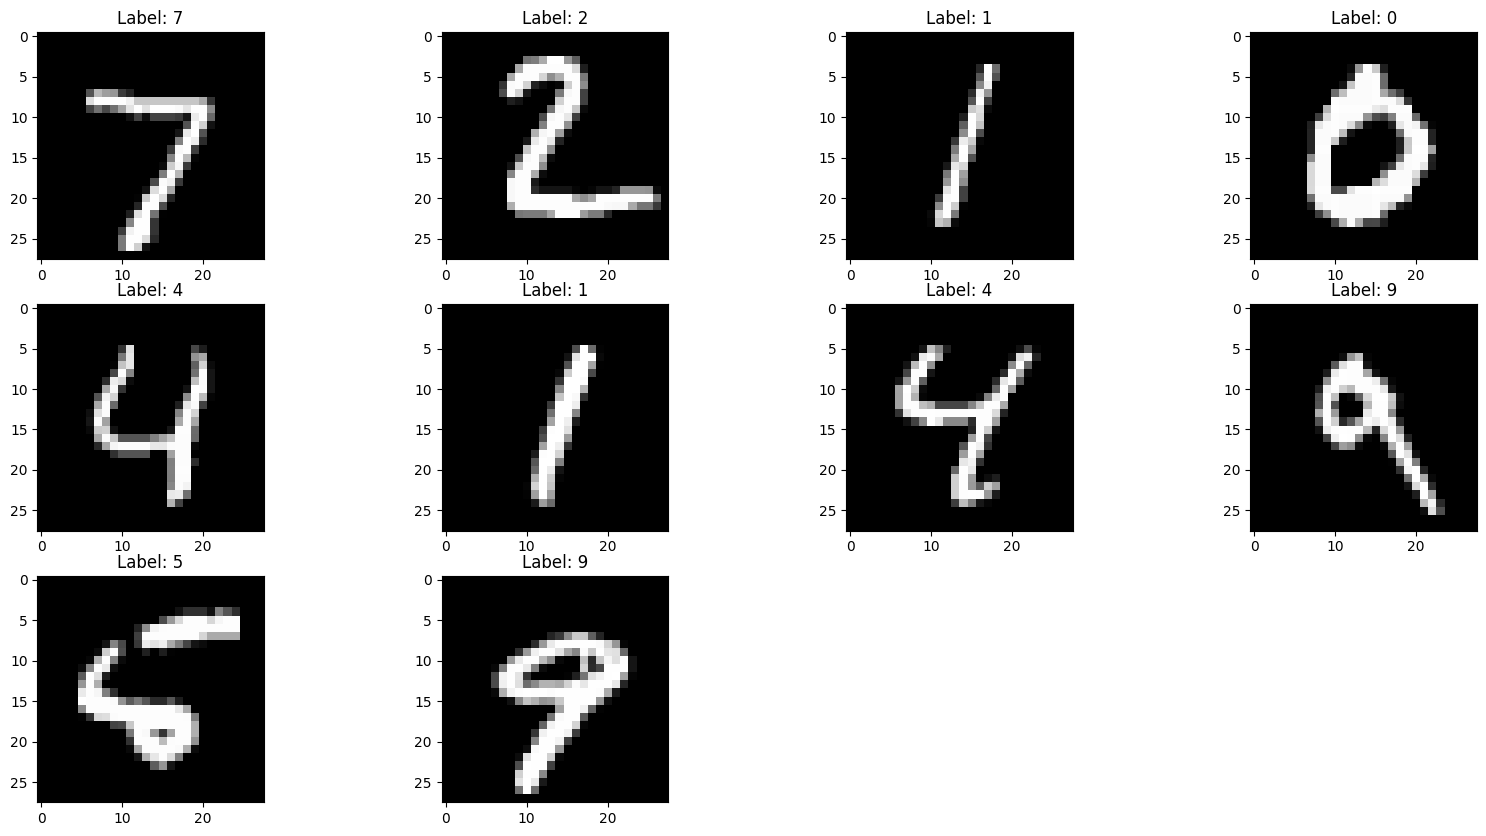

In [22]:
display_images(X_test[:10], y_test[:10])

In [23]:
# Reshape X_test to 1D array
X_test = X_test.reshape(X_test.shape[0], -1).to(device)

# Scale the test data
X_test = X_test.float() / 255.0

# Encode Label
y_test = encoder.transform(y_test.reshape(-1, 1))
y_test = torch.tensor(y_test.toarray(), dtype=torch.float32).to(device)

In [24]:
correct = 0

for i in range(len(X_test)):
    X = X_test[i]
    y_pred = predict(X, theta, bias)
    print(f"Actual: {y_test[i].argmax()}, Predicted: {y_pred}")
    if y_pred == torch.argmax(y_test[i]):
        correct += 1

accuracy = (correct / len(X_test)) * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Actual: 7, Predicted: 7
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 4, Predicted: 4
Actual: 1, Predicted: 1
Actual: 4, Predicted: 4
Actual: 9, Predicted: 9
Actual: 5, Predicted: 6
Actual: 9, Predicted: 9
Actual: 0, Predicted: 0
Actual: 6, Predicted: 6
Actual: 9, Predicted: 9
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 5, Predicted: 5
Actual: 9, Predicted: 9
Actual: 7, Predicted: 7
Actual: 3, Predicted: 3
Actual: 4, Predicted: 4
Actual: 9, Predicted: 9
Actual: 6, Predicted: 6
Actual: 6, Predicted: 6
Actual: 5, Predicted: 5
Actual: 4, Predicted: 4
Actual: 0, Predicted: 0
Actual: 7, Predicted: 7
Actual: 4, Predicted: 4
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 4, Predicted: 6
Actual: 7, Predicted: 7
Actual: 2, Predicted: 2
Actual: 7, Predicted: 7
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 7, Predi